In [4]:
# active inference agent with hierarchical predictive coding model
import numpy as np
import matplotlib.pyplot as plt
import gym


epochs = 1000
inf_num = 100
env = gym.make("CartPole-v0")

def reshapes(l): 
    for i, e in enumerate(l):
        print(i)
        l[i] = np.reshape(np.array(e), (len(e),len(e[0])))
    return l

def reshape_sum_weights(l):
    for i, e in enumerate(l):
        l[i] = np.array(np.sum(e, axis=2))
    return l

def sum_of_squares(l):
    tot = 0
    for e in l:
        tot += np.sum(np.square(e))
    return tot


def run_AI_agent(ret_vals = False):
    d1 = 20
    d2 = 20

    phi = [np.reshape(np.array(env.reset()), (4,1))]
    mu1 = [np.random.normal(size=[d1,1])]
    mu2 = [np.random.normal(size=[d2,1])]
    mu3 = [np.random.normal(size=[d2,1])]
    prevObs = phi[0]

    ez1 = [np.random.normal(size=[4,1])]
    ez2 = [np.random.normal(size=[d1,1])]
    ez3 = [np.random.normal(size=[d2,1])]


    p1 = 0.1
    p2 = 0.1
    p3 = 0.1

    w0 = [np.random.normal(size=[4,d1])]
    w1 = [np.random.normal(size=[d1,d2])]
    w2 = [np.random.normal(size=[d2,d2])]

    wa1 = [np.random.normal(size=[4,1])]
    wa2 = [np.random.normal(size=[4,1])]

    a1 = [0]
    a2 = [0]
    rewards = []
    rewards_per_epoch = []
    actions = []
    diffs1 = [np.reshape(np.array([0,0,0,0]), (4,1))]
    diffs2 = [np.reshape(np.array([0,0,0,0]), (4,1))]

    prior = np.reshape(np.array([0,0,0,0]), (4,1))
    num_resets = 0
    diffs =[0]
    preds = [np.random.normal(size=[4,1])]
    learning_rate = 0.0005
    ds = [prior]
    mu1grads = [np.reshape(np.zeros(d1), (d1,1))]
    tot_rs = []
    rs = []
    for i in range(1,epochs * inf_num):
        if i % inf_num == 0 or i == 1:
            pred = np.dot(w0[i-1], mu1[i-1])
            diffa01 = prior - (pred + wa1[i-1]) 
            diffa02 = prior - (pred + wa2[i-1])
            diff = np.sum(np.abs(diffa01)) - np.sum(np.abs(diffa02))
            #print(diff)
            if diff >=0:
                # a1 is best
                action = 0
                a1.append(1)
                a2.append(0)
            else:
                action = 1
                a1.append(0)
                a2.append(1)

            o, r, done, info = env.step(action)
            rewards.append(r)
            env.render()
            o = np.reshape(np.array(o), (4,1)) / 3. # divide by 3 for normalization purposes
            phi.append(o)
            prevObs = o
            diffs.append(diff)
            diffs1.append(o - diffa01)
            diffs2.append(o - diffa02)


            if done:
                env.reset()
                prior = np.reshape(np.array([0,0,0,0]), (4,1))
                num_resets +=1
                rewards_per_epoch.append(np.sum(rewards))
                rewards = []
        else:
            #print(phi[i-1])
            phi.append(phi[i-1])
            a1.append(a1[i-1])
            a2.append(a2[i-1])
            diffs.append(diffs[i-1])


        ez1.append(phi[i] - (np.dot(w0[i-1], mu1[i-1]) + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i])))
        ez2.append(mu1[i-1] - np.dot(w1[i-1], mu2[i-1]))
        ez3.append(mu2[i-1] - np.dot(w2[i-1], mu3[i-1]))

        mu1grad = np.dot(w0[i-1].T, ez1[i]) + ez2[i]
        mu2grad = np.dot(w1[i-1].T, ez2[i]) + ez3[i]
        mu3grad = np.dot(w2[i-1].T, ez3[i])
        mu1grads.append(mu1grad)

        mu1.append(mu1[i-1] + (1 * learning_rate * mu1grad))
        mu2.append(mu2[i-1] + (1 * learning_rate * mu2grad))
        mu3.append(mu3[i-1] + (1 * learning_rate * mu3grad))


        d = prior - o
        ds.append(d)
        pred = np.dot(w0[i-1], mu1[i-1])
        diffa01 = prior - (pred + wa1[i-1])
        diffa02 = prior - (pred + wa2[i-1])
        wa1.append(wa1[i-1] + (learning_rate * ((ez1[i] * a1[i]) + (d * a1[i]))))
        wa2.append(wa2[i-1] + (learning_rate * ((ez1[i] * a2[i]) + (d * a2[i]))))

        if i % inf_num == 0:
            # update weights - 
            w0.append(w0[i-1] + (10* learning_rate * np.dot(ez1[i], mu1[i].T))) 
            w1.append(w1[i-1] + (10 * learning_rate * np.dot(ez2[i], mu2[i].T)))
            w2.append(w2[i-1] + (10 * learning_rate * np.dot(ez3[i], mu3[i].T)))

        else:
            w0.append(w0[i-1])
            w1.append(w1[i-1])
            w2.append(w2[i-1])


        preds.append(np.dot(w0[i-1], mu1[i-1]) + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i]))
    rs.append(np.array(rewards_per_epoch))
    if ret_vals:
        return rs, [phi, preds, ez1, ez2, ez3,  mu1,mu2,mu3,wa1,wa2]
    return rs

rs,vals = run_AI_agent(ret_vals=True)
print(np.mean(np.array(rs)))

/home/beren/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


82.27272727272727


In [24]:
#reshape all values into a better format
phi, preds, ez1, ez2, ez3,  mu1,mu2,mu3,wa1,wa2 = reshapes(vals)

0
1
2
3
4
5
6
7
8
9


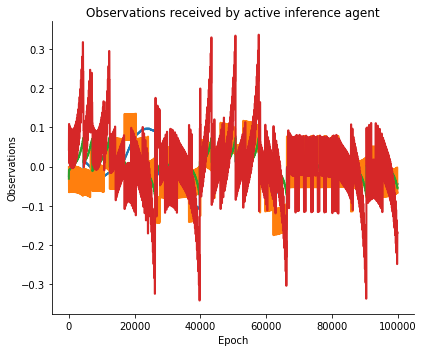

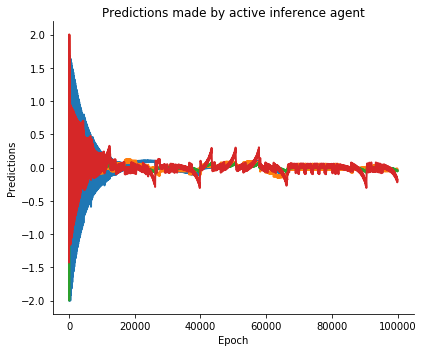

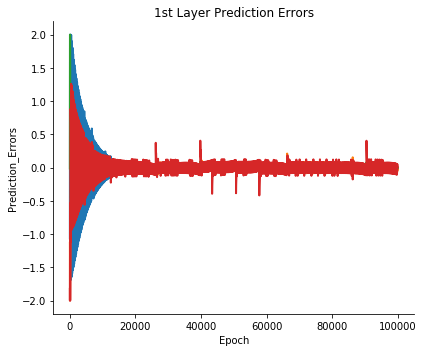

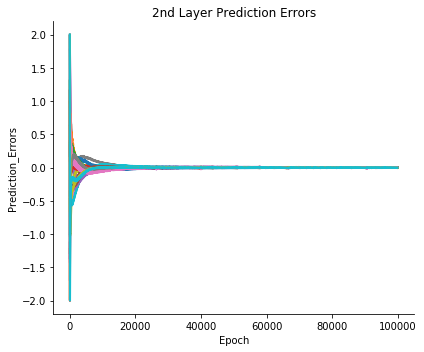

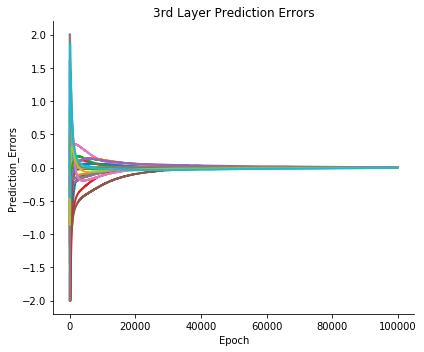

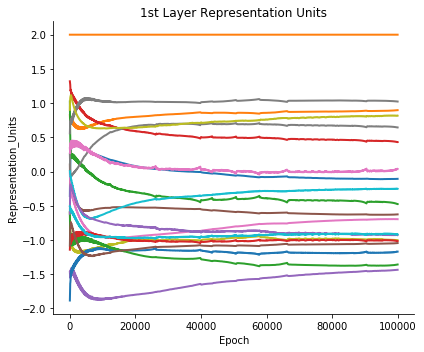

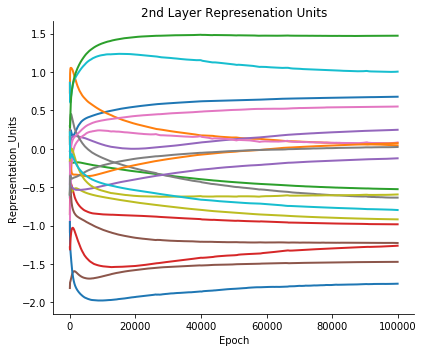

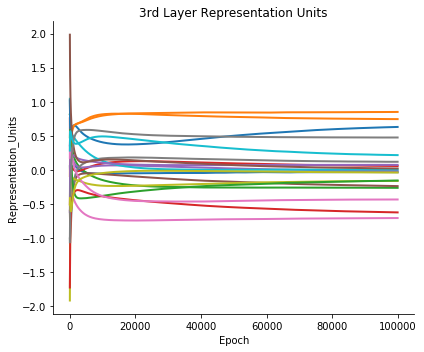

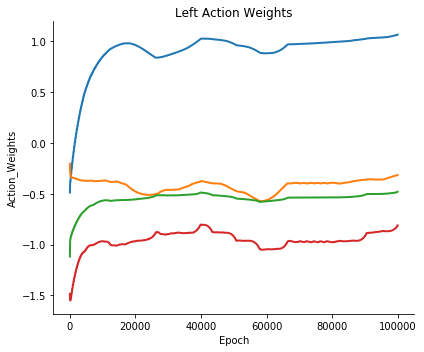

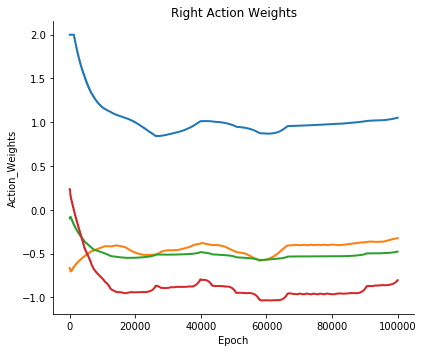

In [23]:
# plot all graphs and save
import seaborn as sn

def clip(xs):
    return [np.clip(x, -2,2) for x in xs]


def plot_graph(val, ylabel, title,savename):
    fig = plt.figure(figsize=(6,5))
    plt.plot(val, ls='-',linewidth=2)
    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.title(title, fontsize=12, pad =5)
    sn.despine(top=True, left=False, right=True, bottom=False)
    plt.tight_layout()
    plt.show()
    fig.savefig("CartPole_results/" + str(savename) + ".pdf", format="pdf", dpi=500)

    
vals = clip([phi, preds, ez1, ez2, ez3, mu1,mu2,mu3,wa1,wa2])
ylabels=["Observations", "Predictions", "Prediction_Errors","Prediction_Errors","Prediction_Errors", "Representation_Units","Representation_Units","Representation_Units","Action_Weights","Action_Weights"]
titles=["Observations received by active inference agent",
       "Predictions made by active inference agent",
       "1st Layer Prediction Errors",
       "2nd Layer Prediction Errors",
       "3rd Layer Prediction Errors",
       "1st Layer Representation Units",
       "2nd Layer Represenation Units",
       "3rd Layer Representation Units",
       "Left Action Weights",
       "Right Action Weights"]
savenames = ["observations","predictions","pe1","pe2","pe3","mu1","mu2","mu3","left_wa","right_wa"]



for (val, ylabel, title,sname) in zip(vals, ylabels, titles,savenames):
    plot_graph(val, ylabel, title, sname)